## Importing Datasets

In [29]:
import re
import numpy as np
import pandas as pd
from tqdm.autonotebook import tqdm

In [ ]:
string_df = pd.read_csv(f"data/train_test/bin_test0.csv",dtype=str)
balanced_pairs_df = pd.read_csv(f"data/train_test/bin_test_pairs.csv", index_col=0)

balanced_pairs_df.drop_duplicates(inplace=True)
balanced_pairs_df.reset_index(drop=True, inplace=True)
print(string_df.head())
print(balanced_pairs_df.head())

             label                                       concatenated
0  GooglePixel3A_L  0000000000000000000000000000000000000000000000...
1  GooglePixel3A_L  0000000000000000000000000000000000000000000000...
2  GooglePixel3A_L  0000000000000000000000000000000000000000000000...
3  GooglePixel3A_L  0000000000000000000000000000000000000000000000...
4  GooglePixel3A_L  0000000000000000000000000000000000000000000000...
   Item 1  Item 2  Equality         device1         device2
0     472     504         1  XiaomiRedmi5_J  XiaomiRedmi5_J
1     451     473         1  XiaomiRedmi5_J  XiaomiRedmi5_J
2     207     277         1     SamsungS4_C     SamsungS4_C
3     263     307         1     SamsungS4_C     SamsungS4_C
4     410     425         1  XiaomiRedmi4_B  XiaomiRedmi4_B


## Importing Best Configurations

In [32]:

def parse_log_file(filename):
    data = []

    with open(filename, "r") as file:
        lines = file.readlines()

        current_filter = None
        current_threshold = None
        current_min_error = None
        current_confidence = None

        for line in lines:
            if "Best Filter" in line:
                # Extract Best Filter using regex
                filter_match = re.search(r"Best Filter: (.+)", line)
                if filter_match:
                    current_filter = filter_match.group(1).strip()

            elif "Best Threshold" in line:
                # Extract Best Threshold using regex
                threshold_match = re.search(r"Best Threshold: (.+)", line)
                if threshold_match:
                    current_threshold = int(threshold_match.group(1).strip())

            elif "Min error" in line:
                # Extract Min Error using regex
                min_error_match = re.search(r"Min error: (.+)", line)
                if min_error_match:
                    current_min_error = float(min_error_match.group(1).strip())

            elif "Confidence" in line:
                # Extract Confidence using regex
                confidence_match = re.search(r"Confidence: (.+)", line)
                if confidence_match:
                    current_confidence = float(confidence_match.group(1).strip())

                    # Once we have all values, create a tuple and add it to the data list
                    data.append(
                        (
                            current_filter,
                            current_threshold,
                            current_min_error,
                            current_confidence,
                        )
                    )

                    # Reset current values for the next entry
                    current_filter = None
                    current_threshold = None
                    current_min_error = None
                    current_confidence = None

    # Convert the list of tuples into a DataFrame
    df = pd.DataFrame(
        data, columns=["Best Filter", "Best Threshold", "Min Error", "Confidence"]
    )

    return df

In [ ]:
# Usage example:
log_filename = "bamboo.log"
best_configs_df = parse_log_file(log_filename)
print(best_configs_df.head())
M = 0

                       Best Filter  Best Threshold  Min Error  Confidence
0            0[8] ooooxxxx 0[1768]               1   0.231102    1.202102
1          0[328] xxxxoooo 0[1448]               1   0.233433    1.189026
2          0[360] xxxxxxxx 0[1416]               1   0.233991    1.185909
3  0[352] ooooooooxxxxxxxx 0[1416]               1   0.233991    1.185909
4  0[352] xxxxxxxxxxxxxxxx 0[1416]               1   0.233991    1.185909


In [34]:
if M != 0:
    best_configs_df = best_configs_df.head(M)

if M == 0:
    M = len(best_configs_df)

# Calculate compression rate (number of bits before / number of bits after)
# number of bits before is the length of the concatenated string
# number of bits after is the number of filters used (M)
compression_rate = len(string_df["concatenated"].iloc[0]) / best_configs_df.shape[0]

print("Compression Rate:", compression_rate)

Compression Rate: 27.875


## Generate Matrix

In [35]:
def convertColumntoArray(df: pd.DataFrame, column_name: str) -> np.array:
    return np.array([list(bstr) for bstr in df[column_name]])

In [36]:
def generateStringPairDf(pairs_df: pd.DataFrame, dataset: pd.DataFrame) -> pd.DataFrame:
    # Convert the Probes column to a numpy array
    dataset_array = convertColumntoArray(dataset, "concatenated")

    return_df = pd.DataFrame()

    # Import the Probes into the pairs_df dataframe
    return_df["Item 1"] = pairs_df["Item 1"].apply(lambda index: dataset_array[index])
    return_df["Item 2"] = pairs_df["Item 2"].apply(lambda index: dataset_array[index])
    return_df["Equality"] = pairs_df["Equality"]

    return return_df

In [37]:
matrix_pairs_df = generateStringPairDf(balanced_pairs_df, string_df)
matrix_pairs_df.reset_index(inplace=True, drop=True)

## Filters Parser

In [11]:
def filter_parser(input_string: str) -> list:
    # Split the string into its parts
    parts = input_string.split()

    # Initialize the final array
    result = []

    # Process each part
    for part in parts:
        if part.startswith("0["):
            # Extract the number inside the brackets
            count = int(part[2:-1])
            # Append the corresponding number of zeros to the result
            result.extend([0] * count)
        else:
            # Translate the tiles to their respective values
            for char in part:
                if char == "o":
                    result.append(-1)
                elif char == "x":
                    result.append(1)

    return result

## Calculate Fingerprint

In [ ]:
def hamming_distance(array1, array2, confidence):
    # Check if arrays have the same length
    if len(array1) != len(array2):
        raise ValueError("Arrays must have the same length")

    # Initialize distance counter
    distance = 0

    # Iterate through arrays and count differences
    for i in range(len(array1)):
        if array1[i] != array2[i]:
            distance += 1

    return distance

def calculate_single_fprint(item, best_filters, best_thresholds):
    fingerprint = []

    for best_filter, best_threshold in zip(best_filters, best_thresholds):
        filtered = np.sum(np.multiply(item.astype(int), filter_parser(best_filter)))

        if filtered > best_threshold:
            filtered = 1
        else:
            filtered = -1

        fingerprint.append(filtered)

    return fingerprint

In [19]:
# Extracting best filters and thresholds from the main DataFrame (assuming same filters and thresholds for simplicity)
best_filters = best_configs_df["Best Filter"].tolist()
best_thresholds = best_configs_df["Best Threshold"].tolist()

matrix_pairs_df["fprint1"] = matrix_pairs_df["Item 1"].apply(
    lambda item: calculate_single_fprint(item, best_filters, best_thresholds)
)
matrix_pairs_df["fprint2"] = matrix_pairs_df["Item 2"].apply(
    lambda item: calculate_single_fprint(item, best_filters, best_thresholds)
)
for M in tqdm([8,16,32,64],total=4):
    matrix_pairs_df[f"h_distance_{M}"] = matrix_pairs_df.apply(
        lambda row: hamming_distance(
            row["fprint1"][:M], row["fprint2"][:M], confidence=0.0
        ),
        axis=1,
    )
    print(f"Calculated Hamming distances for M={M}")

 25%|██▌       | 1/4 [00:00<00:00,  4.26it/s]

Calculated Hamming distances for M=8


 50%|█████     | 2/4 [00:00<00:00,  4.31it/s]

Calculated Hamming distances for M=16


 75%|███████▌  | 3/4 [00:00<00:00,  4.05it/s]

Calculated Hamming distances for M=32


100%|██████████| 4/4 [00:01<00:00,  3.93it/s]

Calculated Hamming distances for M=64


In [ ]:
matrix_pairs_df.to_csv(f"data/outputs/bamboo/bamboo_fingerprint_matrix_pairs.csv", index=False)

## BUILD ROC DATA

In [ ]:
from sklearn.metrics import roc_curve
import numpy as np
import pandas as pd

best_tau_rows = []

for M in [8, 16, 32, 64]:
    # distances and labels
    dist = matrix_pairs_df[f"h_distance_{M}"].to_numpy()
    y = matrix_pairs_df["Equality"].to_numpy()

    # map {-1,+1} → {0,1}
    y01 = (y == 1).astype(int)

    # score for ROC: higher = more positive
    scores = -dist

    # ROC
    fpr, tpr, thr = roc_curve(y01, scores)

    # remove first ROC point (threshold = +inf)
    fpr, tpr, thr = fpr[1:], tpr[1:], thr[1:]

    # ---------- BEST TAU (closest to (0,1)) ----------
    roc_dist = np.sqrt(fpr**2 + (1 - tpr)**2)
    i_best = np.argmin(roc_dist)

    best_tau = -thr[i_best]  # convert score threshold → distance τ
    best_tau_rows.append({
        "M": M,
        "best_tau": best_tau,
        "tpr": tpr[i_best],
        "fpr": fpr[i_best],
        "dist_to_(0,1)": roc_dist[i_best],
    })

    # ---------- SAVE FULL ROC DATA ----------
    roc_data = pd.DataFrame({
        "fpr": fpr,
        "tpr": tpr,
        "tau": -thr,   # store τ explicitly (important!)
    })

    roc_data.to_csv(
        f"results/bamboo/roc_curve_data_{M}.csv",
        index=False
    )

# ---------- SAVE BEST TAU SUMMARY ----------
best_tau_df = pd.DataFrame(best_tau_rows)
print(best_tau_df)


    M  best_tau       tpr       fpr  dist_to_(0,1)
0   8      -0.0  0.900926  0.046954       0.109637
1  16       1.0  0.879199  0.027874       0.123975
2  32       3.0  0.941691  0.062279       0.085314
3  64       3.0  0.932941  0.036411       0.076307


## PLOT ROC DATA

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def plot_roc_curves_from_files(csv_files, labels, output_file):
    if not csv_files or not labels or len(csv_files) != len(labels):
        print("Invalid input: Ensure that csv_files and labels are non-empty and of the same length.")
        return

    plt.figure(figsize=(6.5, 5.5))

    line_styles = ["-", "--", "-.", ":"]
    markers = ["o", "s", "^", "d", "*"]
    style_count = 0

    for csv_file, label in zip(csv_files, labels):
        roc_data = pd.read_csv(csv_file)

        fpr = roc_data["fpr"].to_numpy()
        tpr = roc_data["tpr"].to_numpy()

        # sort
        order = np.argsort(fpr)
        fpr = fpr[order]
        tpr = tpr[order]

        # deduplicate FPR (keep max TPR for each FPR)
        df = pd.DataFrame({"fpr": fpr, "tpr": tpr}).groupby("fpr", as_index=False)["tpr"].max()
        fpr_u = df["fpr"].to_numpy()
        tpr_u = df["tpr"].to_numpy()

        # Ensure ROC endpoints exist
        if fpr_u[0] > 0:
            fpr_u = np.insert(fpr_u, 0, 0.0)
            tpr_u = np.insert(tpr_u, 0, 0.0)

        if fpr_u[-1] < 1:
            fpr_u = np.append(fpr_u, 1.0)
            tpr_u = np.append(tpr_u, 1.0)
        # interpolate robustly
        fpr_interpolated = np.linspace(0, 1, 100)
        tpr_interpolated = np.interp(fpr_interpolated, fpr_u, tpr_u)

        roc_auc = auc(fpr_interpolated, tpr_interpolated)

        line_style = line_styles[style_count % len(line_styles)]
        marker = markers[style_count % len(markers)]
        plt.plot(
            fpr_interpolated,
            tpr_interpolated,
            linestyle=line_style,
            marker=marker,
            markevery=5,
            markersize=7,
            lw=2,
            label=f"{label} (AUC = {roc_auc:.2f})"
        )

        style_count += 1

    plt.plot([0, 1], [0, 1], color="grey", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.minorticks_on()
    plt.tick_params(axis="both", which="both", direction="in", top=True, right=True)
    plt.grid(True, which="minor", color="gray", linestyle=":", linewidth=0.5)

    plt.savefig(output_file, format="pdf")
    plt.show()
    plt.close()


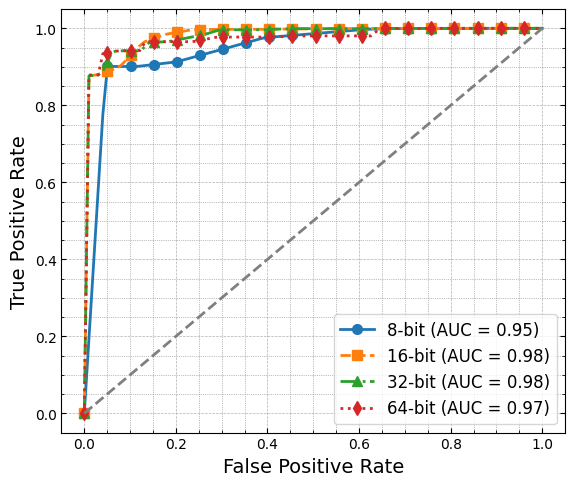

In [ ]:

M_range = [8,16,32,64]
csv_files = [f'results/bamboo/roc_curve_data_{M}.csv' for M in M_range]
labels = [f'{M}-bit' for M in M_range]
output_file = 'roc_image.pdf'
plot_roc_curves_from_files(csv_files, labels, output_file)